### Recession Model Prediction: Model Comparison 

#### Author: Christina Lv 


In [29]:
#!source /Users/akalodzitsa/Documents/Engagements/Market_and_Sector_Forecasting/KPMG_forecasting_model/venv/bin/activate

In [30]:
#pip install yfinance

In [31]:
#pip install quandl


In [32]:
#pip install plotly 

In [33]:
import pandas as pd 
import numpy as np 
import quandl 
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt 

import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px

In [34]:
#! pip install quandl
import quandl
quandl.ApiConfig.api_key = 'AtPuHRXs-rLGozrAYSKk'

#### Part 1: Retrieve Data - Predictive Variables

*1. Recession inferred by GDP*

*2. Fed funds rate*

*3. Unemployment rate*

*4. CPI: proxy for inflation*

*5 & 6. 10-year and 3-month Treasury Bond Yield*

In [35]:
recession_data = quandl.get("FRED/USRECQP", collapse="monthly") 
fed_funds_data = quandl.get("FRED/FEDFUNDS", collapse="monthly") 
unemploy_data = quandl.get("FRED/UNEMPLOY", collapse="monthly")
cpi_data = quandl.get("RATEINF/CPI_USA", collapse="monthly") 

ten_year = quandl.get("FRED/DGS10", collapse="daily") #10-Year Treasury Constant Maturity Rate
three_month = quandl.get("FRED/DTB3", collapse="daily") #3-month treasury bill - secondary market rate 

In [36]:
data = pd.DataFrame()
data['fed_funds'] = fed_funds_data.Value
data['unemploy'] = unemploy_data.Value
data['cpi'] = cpi_data.Value
data['recession'] = recession_data.Value
data['3_month'] = three_month.Value
data['10YR'] = ten_year.Value
data

,fed_funds,unemploy,cpi,recession,3_month,10YR
Date,,,,,,
1954-07-31,0.80,3659.0,26.900,0.0,NaN,NaN
1954-08-31,1.22,3854.0,26.900,NaN,1.05,NaN
1954-09-30,1.07,3927.0,26.800,NaN,0.99,NaN
1954-10-31,0.85,3666.0,26.800,0.0,NaN,NaN
1954-11-30,0.83,3402.0,26.800,NaN,1.01,NaN
...,...,...,...,...,...,...
2021-08-31,0.09,8339.0,273.567,NaN,0.04,1.30
2021-09-30,0.08,7666.0,274.310,NaN,0.04,1.52
2021-10-31,0.08,7375.0,276.589,0.0,NaN,NaN


In [37]:
data['recession'].isna().sum()

540

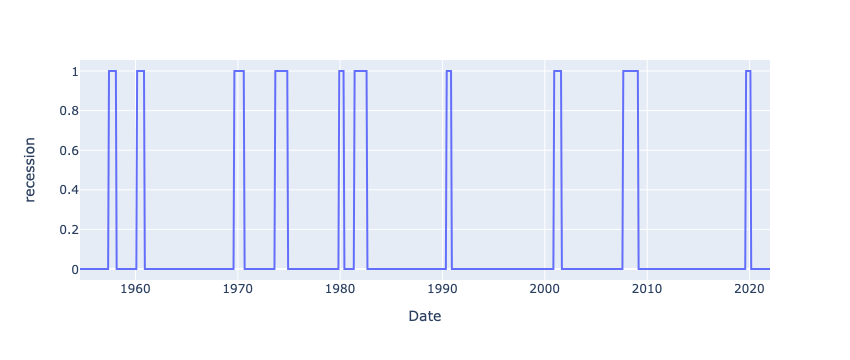

In [38]:
data["recession"] = data["recession"].fillna(method='bfill').fillna(method='ffill')
px.line(data, x= data.index, y='recession')

In [39]:
data.head()

,fed_funds,unemploy,cpi,recession,3_month,10YR
Date,,,,,,
1954-07-31,0.80,3659.0,26.9,0.0,NaN,NaN
1954-08-31,1.22,3854.0,26.9,0.0,1.05,NaN
1954-09-30,1.07,3927.0,26.8,0.0,0.99,NaN
1954-10-31,0.85,3666.0,26.8,0.0,NaN,NaN
1954-11-30,0.83,3402.0,26.8,0.0,1.01,NaN


In [40]:
data.columns

Index(['fed_funds', 'unemploy', 'cpi', 'recession', '3_month', '10YR'], dtype='object')

#### Part 2: Data Transformation

*1. Recession inferred by GDP*

*2. Fed funds rate*

*3. Unemployment rate*: lagging indicator 

*4. CPI: proxy for inflation*

*5. Term Spread*

In [41]:
#Specify log differential function
def log_diff(v): 
    log_diff = np.log(v/v.shift(1))
    return log_diff 

In [42]:
data["yield_spread"] = (data['10YR'] - data['3_month']) #Calculate yield spread by taking the difference
data["fedfunds"] = data["fed_funds"].diff() 
data["unemploy_rate"] = log_diff(data["unemploy"])
data["cpi_index"] =  log_diff(data["cpi"])

In [43]:
#Robobank Reference: https://research.rabobank.com/publicationservice/download/publication/token/8Wsu7NXGcHfF4ZkWAkjg
data['adjusted_yield'] = (data["yield_spread"] - 2.616 + 0.808 * np.log(data['3_month'] + 1))

In [44]:
#Drop raw data after transformations are made
data = data.drop(['fed_funds','unemploy','cpi', '10YR', '3_month'], axis=1)

In [45]:
data = data[data['yield_spread'].notna()]

In [46]:
data

,recession,yield_spread,fedfunds,unemploy_rate,cpi_index,adjusted_yield
Date,,,,,,
1962-01-31,0.0,1.37,-0.18,-0.023251,0.000000,-0.182342
1962-02-28,0.0,1.29,0.22,-0.052829,0.003328,-0.266686
1962-04-30,0.0,1.12,-0.07,-0.003833,0.003317,-0.430179
1962-05-31,0.0,1.20,-0.42,-0.011070,0.000000,-0.358867
1962-07-31,0.0,1.18,0.03,-0.006525,0.003306,-0.344661
...,...,...,...,...,...,...
2021-06-30,0.0,1.40,0.02,0.026771,0.009248,-1.176578
2021-08-31,0.0,1.26,-0.01,-0.039041,0.002064,-1.324310
2021-09-30,0.0,1.48,-0.01,-0.084148,0.002712,-1.104310


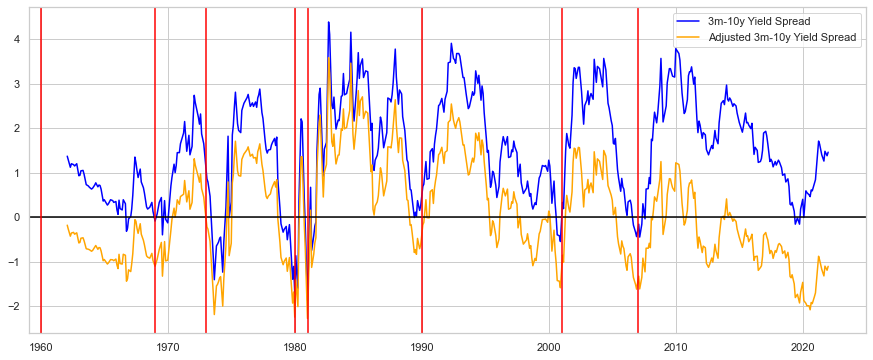

In [47]:
#Visualize the comparison between adjusted yield spread and 3m-10y yield spread
import datetime as dt
import seaborn as sns


sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.plot(data["yield_spread"], color='blue', label='3m-10y Yield Spread')
plt.plot(data['adjusted_yield'], color='orange', label='Adjusted 3m-10y Yield Spread')
plt.legend()

plt.axhline(0, color='black')

years = [1960, 1969, 1973, 1980, 1981, 1990, 2001, 2007]

for year in years:
    plt.axvline(dt.datetime(year, 1, 1), color='red')

### Part 3: New NBER Dates

In [48]:
#NBERt,t+12, equals one if there is an NBER recession starting at any time in the 12 months that follow the observed independent variables, and zero otherwise.

from datetime import date, timedelta

new_recession = []
for index, row in data.iterrows():
    if (index >= date(2020,8,31)): # NOTE: remember to update this date so it is always 12 month earlier than the latest month in data
        break
    new_value = 0
    for index2, row2 in data.iterrows():
        if (index2 > index) and ((index2 - index).days <= 365):
            if (row2['recession'] > 0.0):
                new_value = 1
    new_recession.append(new_value)        

In [49]:
for i in range(8):
    new_recession.append(0)

In [50]:
len(new_recession)

500

In [51]:
data['adjusted_recession'] = new_recession

ValueError: Length of values (500) does not match length of index (503)

### New Part 4: Model Testing 

In [ ]:
data = data.reset_index()

In [ ]:
data

In [ ]:
# Convert Month into Datetime
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

In [ ]:
X = data.drop(['adjusted_recession','recession','yield_spread'],axis=1)
y = data["adjusted_recession"]

In [ ]:
X

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


clfs = {"Gaussian": GaussianNB(),
       "SVM": SVC(kernel='rbf', probability=True),
       "Random Forest": RandomForestClassifier(max_depth=15, 
                                                      n_estimators=200, 
                                                      class_weight = "balanced_subsample", 
                                                      random_state=42)}

In [ ]:
X_train, y_train =  (X.loc["1962-01-31":"2006-01-31"], y.loc["1962-01-31":"2006-01-31"])
X_test_withNA, y_test_withNA =  (X.loc["2006-01-31":], y.loc["2006-01-31":])

In [ ]:
y_test = y_test_withNA[:-8]

In [ ]:
X_test = X_test_withNA[:-8]

In [ ]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for name, clf in clfs.items(): 
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{name} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=900, height=700
)
fig.update_layout(title_text="Comparing different models")
fig.show()

In [ ]:
model = SVC(kernel='rbf', probability=True).fit(X_train, y_train)
predictions = model.predict(X_test)
score = accuracy_score(y_test,predictions)
report = classification_report(y_test,predictions)
print(score)
print(report)

In [ ]:
plot_proba = pd.DataFrame()
plot_proba['recession_proba'] = model.predict_proba(X_test)[:,1]

In [ ]:
len(plot_proba)

In [ ]:
plot_proba = pd.DataFrame()
plot_proba['recession_proba'] = model.predict_proba(X_test_withNA)[:,1]

The figure generated below shows the 12-month-look-ahead probability of recession. As observed, significant surge of recession probability appears in the year of 2007, which corresponds to the then upcoming recession in 2008.

In [ ]:
fig = go.Figure()
fig.add_scatter(x= X_test_withNA.index, y=plot_proba["recession_proba"], mode='lines',name="Prediction Results")


fig.update_layout(

xaxis_title='Time',
yaxis_title='Recession Probability'
)

fig.update_layout(title_text="Recession Probability Prediction 12 Months Ahead")
fig.show()

In [ ]:
to_save = X_test_withNA.copy()

In [ ]:
to_save['predicted_probability'] = model.predict_proba(X_test_withNA)[:,1]

In [ ]:
to_save = to_save.drop(['fedfunds', 'unemploy_rate', 'cpi_index', 'adjusted_yield'], axis=1)

In [ ]:
to_save

This "to_save" data frame contains the predicted probability of whether there will be a recession in the upcoming 12 months at the given date. For example, a row with "date" being 2006-01-31 and "predicted probability" of 0.3959 means that, the model predicts between 2006-01-31 and 2007-01-31 the probability of having a recesion is 39.59%

In [ ]:
to_save.to_csv('out_sample_recession_probability.csv')

### In sample predictiom

In [ ]:
in_sample_predictions = model.predict(X_train)
in_sample_score = accuracy_score(y_train,in_sample_predictions)
in_sample_report = classification_report(y_train,in_sample_predictions)
print(in_sample_score)
print(in_sample_report)

In [ ]:
X_train

In [ ]:
in_sample_to_save = X_train.copy()

In [ ]:
in_sample_to_save['predicted_probability'] = model.predict_proba(X_train)[:,1]

In [ ]:
in_sample_to_save = in_sample_to_save.drop(['fedfunds', 'unemploy_rate', 'cpi_index', 'adjusted_yield'], axis=1)

In [ ]:
# save from year 1980 and hopefully it is early enough, feel free to adjust
in_sample_to_save[150::]

In [ ]:
in_sample_to_save.to_csv('in_sample_recession_probability.csv')